<a href="https://colab.research.google.com/github/sanjames/DataProjects/blob/master/Fraud_Detection_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fraud Detection Keras**

Google Collab stuffs to access the data

In [0]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_list = drive.ListFile({'q': "'1X5iho5q-AgoGb8xXh7NeGN-I9i7m79G-' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Fraud Detection-Keras, id: 1MFNh8lpUh731gPQCfLf_b_SuJYUT1KPC
title: Google Analytics Customer Revenue Prediction.ipynb, id: 1WC9p5Il-1R9NdtC2jgXh80YUBs0sC2dg
title: House Price Prediction.ipynb, id: 1EUe5Juzsgw7yYpZIPRGNWiz98K2dJeTN
title: train.csv, id: 1vdER9HlzyRpTXcT_7DR0upKwKOqE9H9q
title: test.csv, id: 1SC68Wz6hazqf0-xueJtXDrZAs6FfaeW4
title: Copy of Hello, Colaboratory, id: 1EtU_Cqecfy520u812ouQnYM5k03Civ2X
title: Keras_tensorboard.ipynb, id: 1I4poc9CGGpcTVUJHYsp5GH2RcGsgDd1W
title: creditcard.csv, id: 1Btd7sPm161bIVityk1F2jLwbVQZkIqrc
title: Lending Club.ipynb, id: 1Q9_tKpqQFjvY15zaqff4lFcREM4U5X90
title: NYC Taxi Rate Prediction.ipynb, id: 1yT1H6qz7Xwc_2jUIaR7RdTgmq6qRJRiT
title: create file in google drive.ipynb, id: 1fpfLLdBg-Nyy5em5SF2qIT-2YH21ryCE
title: Time_series.ipynb, id: 1hFZAfeGUPaG2UlP5u5Zv6R73zuK0HXYr


In [0]:
colabcredit = drive.CreateFile({'id': '1Btd7sPm161bIVityk1F2jLwbVQZkIqrc'})
colabcredit.GetContentFile('creditcard.csv')

# Setup

In [0]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

Using TensorFlow backend.


In [0]:
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Loading data

In [0]:
credit = pd.read_csv('creditcard.csv')

In [0]:
credit.isnull().values.any()

False

In [0]:
credit[['Class', 'Amount']].groupby(['Class'], as_index=False).count().sort_values(by='Class', ascending=True)

,Class,Amount
0,0,284315
1,1,492


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Number of Fraud Txns:  492
Number of non-Fraud Txns:  284315


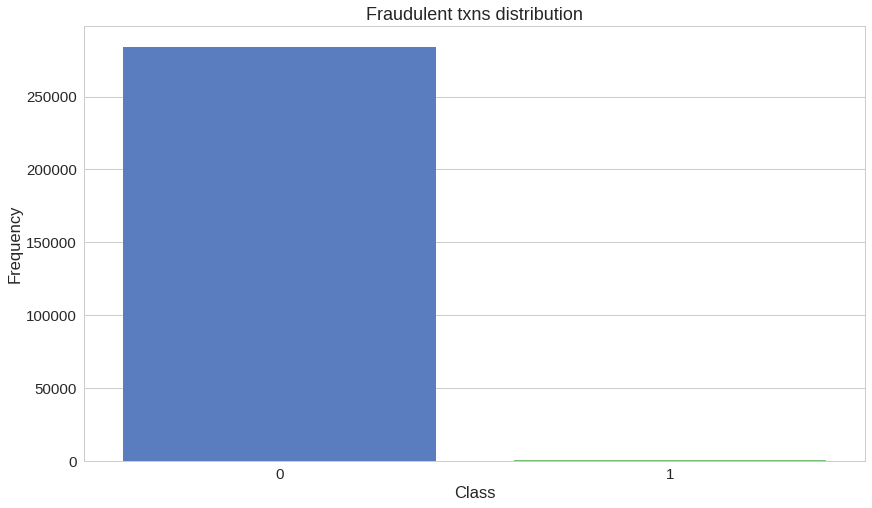

In [0]:
sns.countplot(data=credit, x = 'Class', label='Count')
plt.title("Fraudulent txns distribution")
plt.xlabel("Class")
plt.ylabel("Frequency");

NFraud, Fraud = len(credit[credit['Class']==0]), len(credit[credit['Class']==1])
print('Number of Fraud Txns: ', Fraud)
print('Number of non-Fraud Txns: ', NFraud)

In [0]:
print('Percentage of Fraudulent transactions:',Fraud/len(credit)*100,'%')
print('Percentage of non-fraudulent txns:', NFraud/len(credit)*100,'%')

Percentage of Fraudulent transactions: 0.1727485630620034 %
Percentage of non-fraudulent txns: 99.82725143693798 %


# Imbalanced data

Data is very much imbalanced with fraud txns constituting only .17%.

In [0]:
fraud_credit = credit[credit['Class']==1]
nfraud_credit = credit[credit['Class']==0]

In [0]:
len(fraud_credit), len(nfraud_credit)

(492, 284315)

In [0]:
fraud_credit.shape, nfraud_credit.shape

((492, 31), (284315, 31))

In [0]:
fraud_credit.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [0]:
nfraud_credit.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

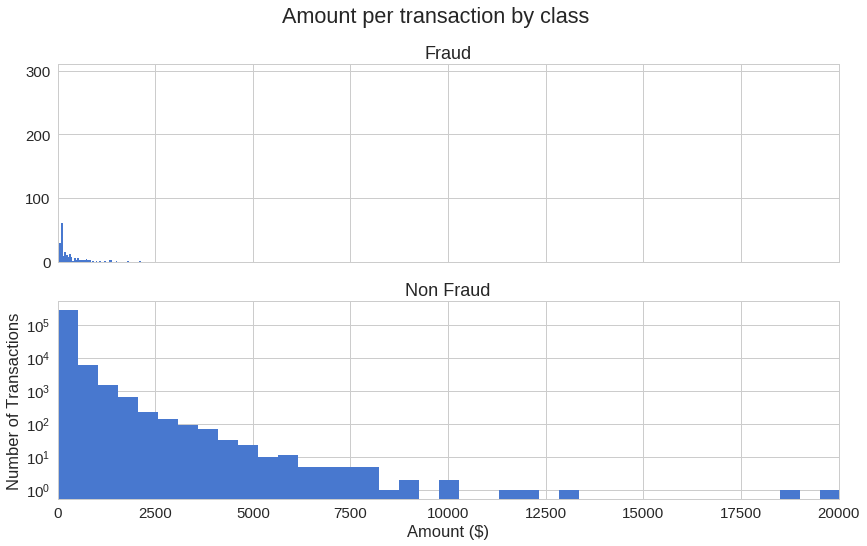

In [0]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(fraud_credit.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(nfraud_credit.Amount, bins = bins)
ax2.set_title('Non Fraud')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

The Amount in fraud txns are not huge amounts. Lets see whether there is any relationship with the time of the transactions

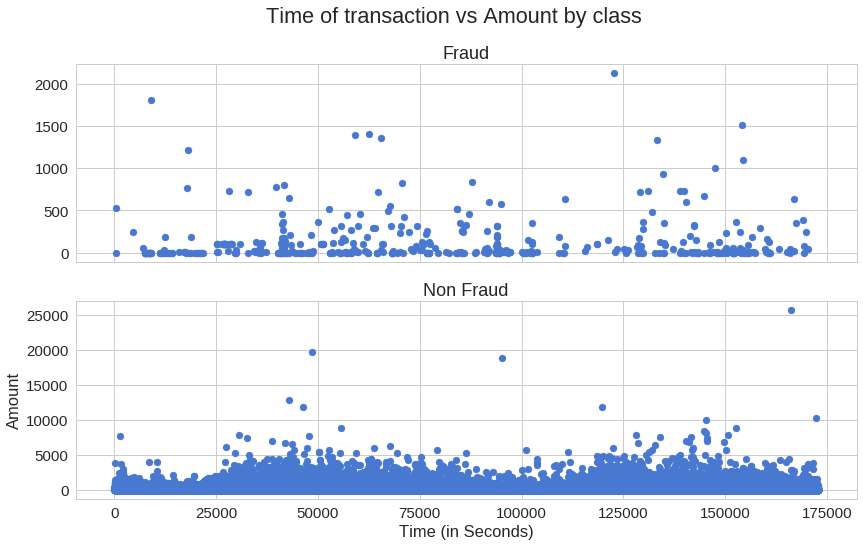

In [0]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraud_credit.Time, fraud_credit.Amount)
ax1.set_title('Fraud')

ax2.scatter(nfraud_credit.Time, nfraud_credit.Amount)
ax2.set_title('Non Fraud')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

There seems to be absolutely no correlation between the 2

# Autoencoders

**Normalization of Data - Amount, time**

In [0]:
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
#from sklearn.preprocessing import StandardScaler
#std_scale = StandardScaler().fit(X_train.Amount.values.reshape(-1,1))
#X_train.Amount = std_scale.transform(X_train)
#X_test.Amount = std_scale.transform(X_test)

In [0]:
amt_mean = credit.Amount.mean(axis=0)
amt_std = credit.Amount.std(axis=0)
time_mean = credit.Time.mean(axis=0)
time_std = credit.Time.std(axis=0)

In [0]:
amt_norm  = credit.Amount - amt_mean
amt_norm =  amt_norm/amt_std
time_norm = credit.Time - time_mean
time_norm = time_norm/time_std

In [0]:
credit['AmountNorm'] = amt_norm
credit['TimeNorm'] = time_norm
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,AmountNorm,TimeNorm
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244964,-1.996580
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342474,-1.996580
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.160684,-1.996558
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.140534,-1.996558
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.073403,-1.996537


In [0]:
train_data = credit.drop(['Time', 'Amount'], axis=1)
train_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,AmountNorm,TimeNorm
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996580
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342474,-1.996580
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160684,-1.996558
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996558
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996537


In [0]:
X_train, X_test = train_test_split(train_data, test_size=0.33, random_state=RANDOM_SEED)
print(X_train.Class.value_counts() ,'\n', X_test.Class.value_counts())

0    190477
1       343
Name: Class, dtype: int64 
 0    93838
1      149
Name: Class, dtype: int64


In [0]:
X_train = X_train[X_train.Class == 0] # Considering only non-fraud txns and training them.
y_train = X_train.Class[X_train.Class == 0] 
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test.Class
X_test = X_test.drop(['Class'], axis=1)
print(y_train.value_counts(), y_test.value_counts())

0    190477
Name: Class, dtype: int64 0    93838
1      149
Name: Class, dtype: int64


In [0]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(190477, 30) (93987, 30) (190477,) (93987,)


Note: Train data has only class 0 - Normal transactions

# Building the model

In [0]:
X_train.shape

(190477, 30)

In [0]:

input_dim = X_train.shape[1]
encoding_dim = 14

In [0]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [0]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 190477 samples, validate on 93987 samples
Epoch 1/100
190477/190477 [==============================] - 46s 244us/step - loss: 0.7370 - acc: 0.6439 - val_loss: 0.7586 - val_acc: 0.6418
Epoch 2/100
190477/190477 [==============================] - 46s 241us/step - loss: 0.7360 - acc: 0.6446 - val_loss: 0.7590 - val_acc: 0.6464
Epoch 3/100
190477/190477 [==============================] - 46s 240us/step - loss: 0.7352 - acc: 0.6439 - val_loss: 0.7611 - val_acc: 0.6446
Epoch 4/100
190477/190477 [==============================] - 45s 239us/step - loss: 0.7353 - acc: 0.6451 - val_loss: 0.7566 - val_acc: 0.6515
Epoch 5/100
190477/190477 [==============================] - 47s 244us/step - loss: 0.7344 - acc: 0.6457 - val_loss: 0.7573 - val_acc: 0.6437
Epoch 6/100
190477/190477 [==============================] - 47s 249us/step - loss: 0.7346 - acc: 0.6449 - val_loss: 0.7558 - val_acc: 0.6525
Epoch 7/100
190477/190477 [==============================] - 47s 244us/step - loss: 0.7343 - acc:

In [0]:
from google.colab import files
files.download('model.h5')

In [0]:
autoencoder = load_model('model.h5')

# Evaluation

In [0]:
history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

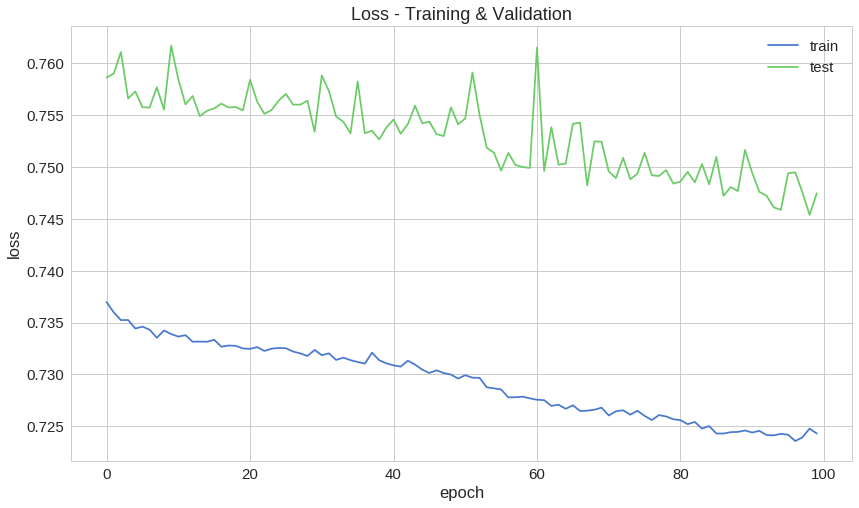

In [0]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss - Training & Validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper right')

In [0]:
predictions = autoencoder.predict(X_test)

In [0]:
predictions

array([[0.        , 1.8953081 , 0.        , ..., 0.        , 3.5211883 ,
        0.        ],
       [0.57035375, 0.        , 0.22536182, ..., 0.        , 0.6443858 ,
        0.        ],
       [1.4797215 , 0.        , 0.25748134, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.8090391 , 0.        , 0.26461506, ..., 0.        , 0.        ,
        0.11779842],
       [1.1891632 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.0340924 , 0.        , 0.        , ..., 0.        , 0.        ,
        1.030756  ]], dtype=float32)

In [0]:
y_test.value_counts()

0    93838
1      149
Name: Class, dtype: int64

In [0]:

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.head()

,reconstruction_error,true_class
43428,78.590799,1
49906,0.834220,0
29474,0.293023,0
276481,0.338613,0
278846,0.160495,0


In [0]:
error_df[error_df.true_class == 1].count()

reconstruction_error    149
true_class              149
dtype: int64

In [0]:
error_df[(error_df.true_class == 0) & (error_df.reconstruction_error < 10)]

,reconstruction_error,true_class
49906,0.729217,0
29474,0.201378,0
276481,0.374118,0
278846,0.164333,0
101565,0.987022,0
260880,0.189166,0
214337,0.427159,0
201575,0.512553,0
81055,2.588724,0
134976,0.304645,0


In [0]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

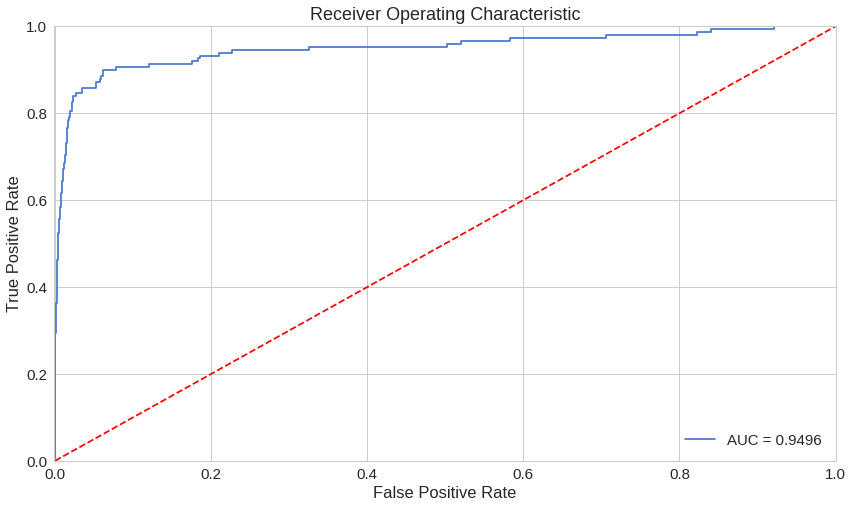

In [0]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

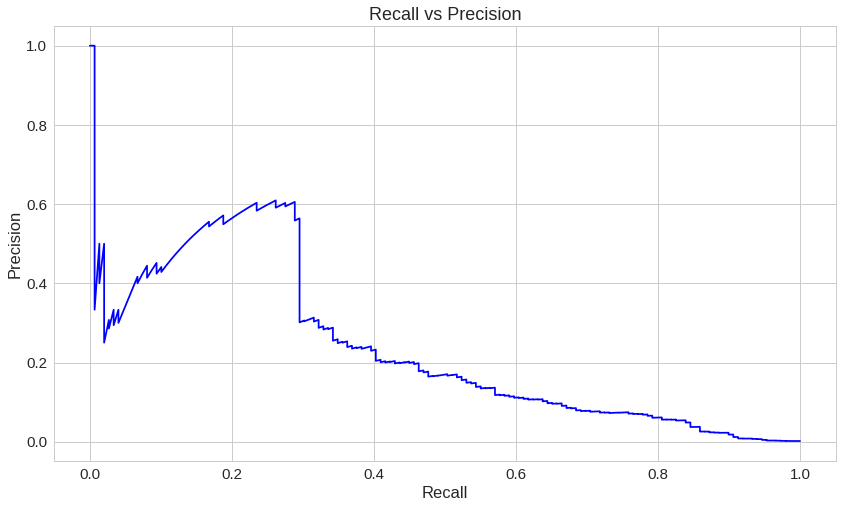

In [0]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

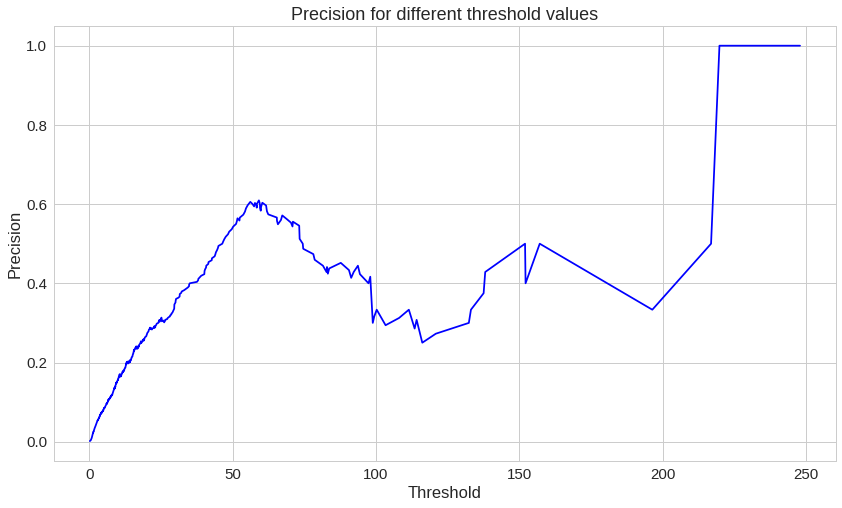

In [0]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

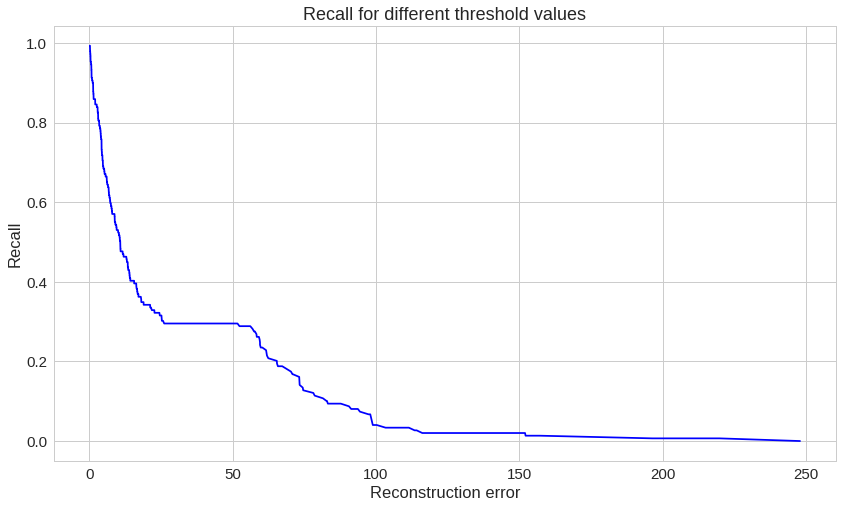

In [0]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

# Threshold

In [0]:
threshold = 3

In [0]:
error_df.groupby('true_class').count()

,reconstruction_error
true_class,
0,93838
1,149


In [0]:
groups = error_df.groupby('true_class')

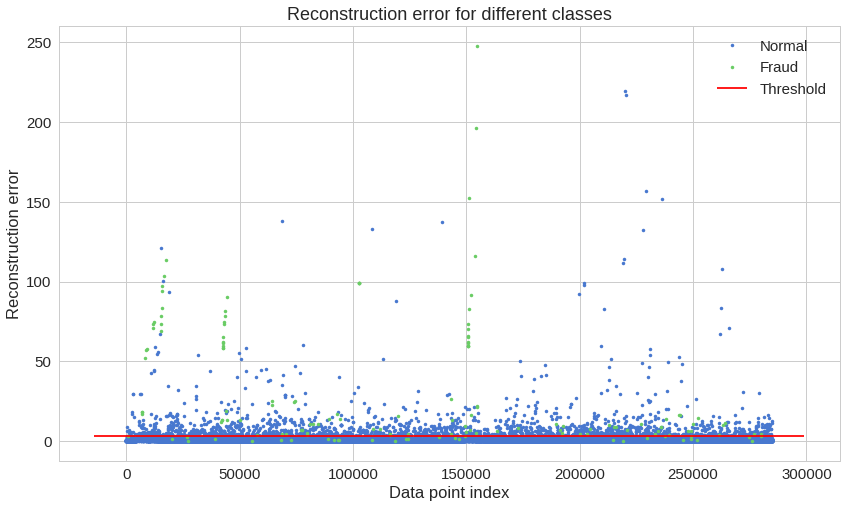

In [0]:
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

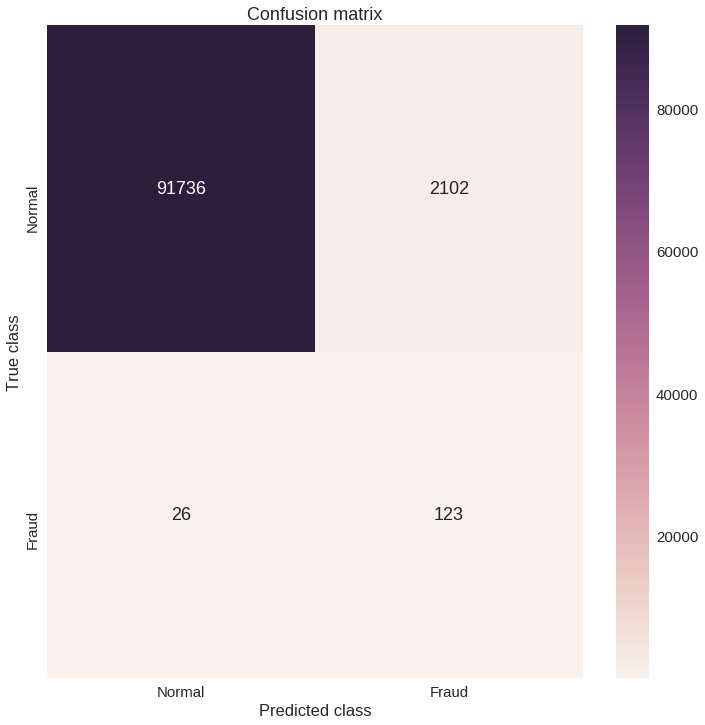

In [0]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [0]:
threshold = 5

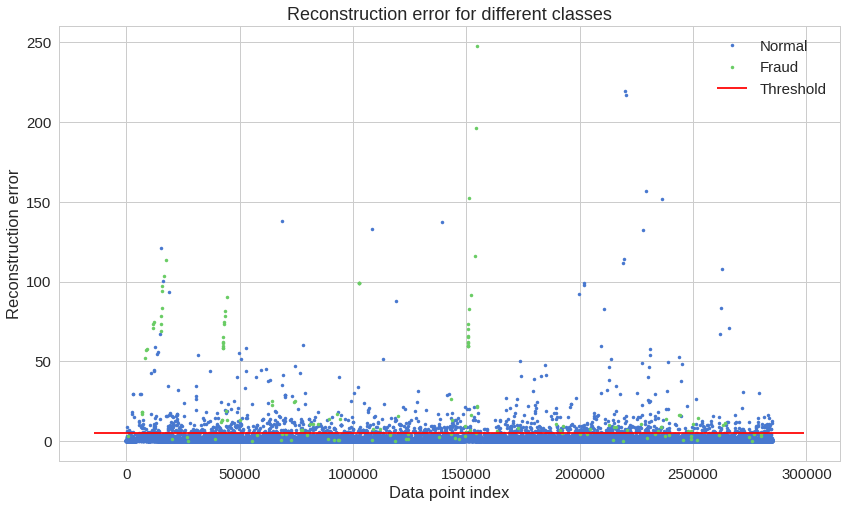

In [0]:
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

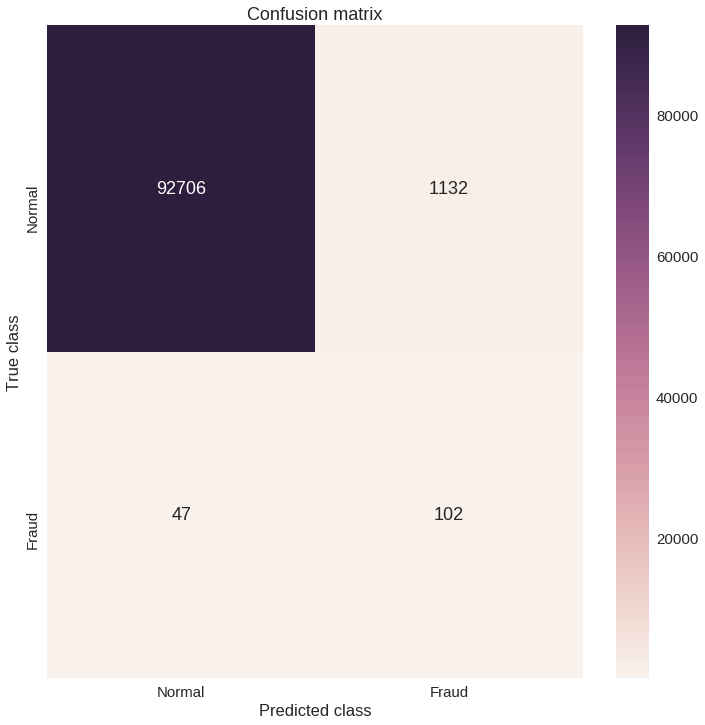

In [0]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2018-11-22 18:55:04--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.173.32.212, 52.44.92.122, 54.172.170.160, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.173.32.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]   5.11M  21.4MB/s    in 0.2s    

2018-11-22 18:55:05 (21.4 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://5589eb93.ngrok.io
